In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("/data/franco/datasets/prot_embedding_weights/prottrans_t5_xl_u50/").to(device)

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('/data/franco/datasets/prot_embedding_weights/prottrans_t5_xl_u50', do_lower_case=False)


In [17]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

test = "P R O T E I N A"


'P R <extra_id_0> <extra_id_1> <extra_id_2> I N A'

In [32]:
import random

testsequence = "PROTEINA"
input_test = [" ".join(list(re.sub(r"[UZOB]", "X", testsequence)))]
print(input_test)

masked_test = [sequence_masker(input_test[0], 2, 3)]
print(masked_test)

ids1 = tokenizer.batch_encode_plus(input_test, add_special_tokens=True, padding="longest")
print(ids1)
ids2 = tokenizer.batch_encode_plus(masked_test, add_special_tokens=True, padding="longest")
print(ids2)

print(tokenizer(input_test[0]))
print(tokenizer(masked_test[0]))

['P R X T E I N A']
['P R <extra_id_0> T E I N A']
{'input_ids': [[13, 8, 23, 11, 9, 12, 17, 3, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[13, 8, 127, 11, 9, 12, 17, 3, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [13, 8, 23, 11, 9, 12, 17, 3, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [13, 8, 127, 11, 9, 12, 17, 3, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [33]:
input_ids = torch.tensor(ids2['input_ids']).to(device)
attention_mask = torch.tensor(ids2['attention_mask']).to(device)

#embfull = fullmodel(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

In [35]:
with torch.no_grad():
    loss = fullmodel(input_ids=input_ids, labels=input_ids).loss
    print(loss.item())

2.058666706085205


In [36]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=input_ids)

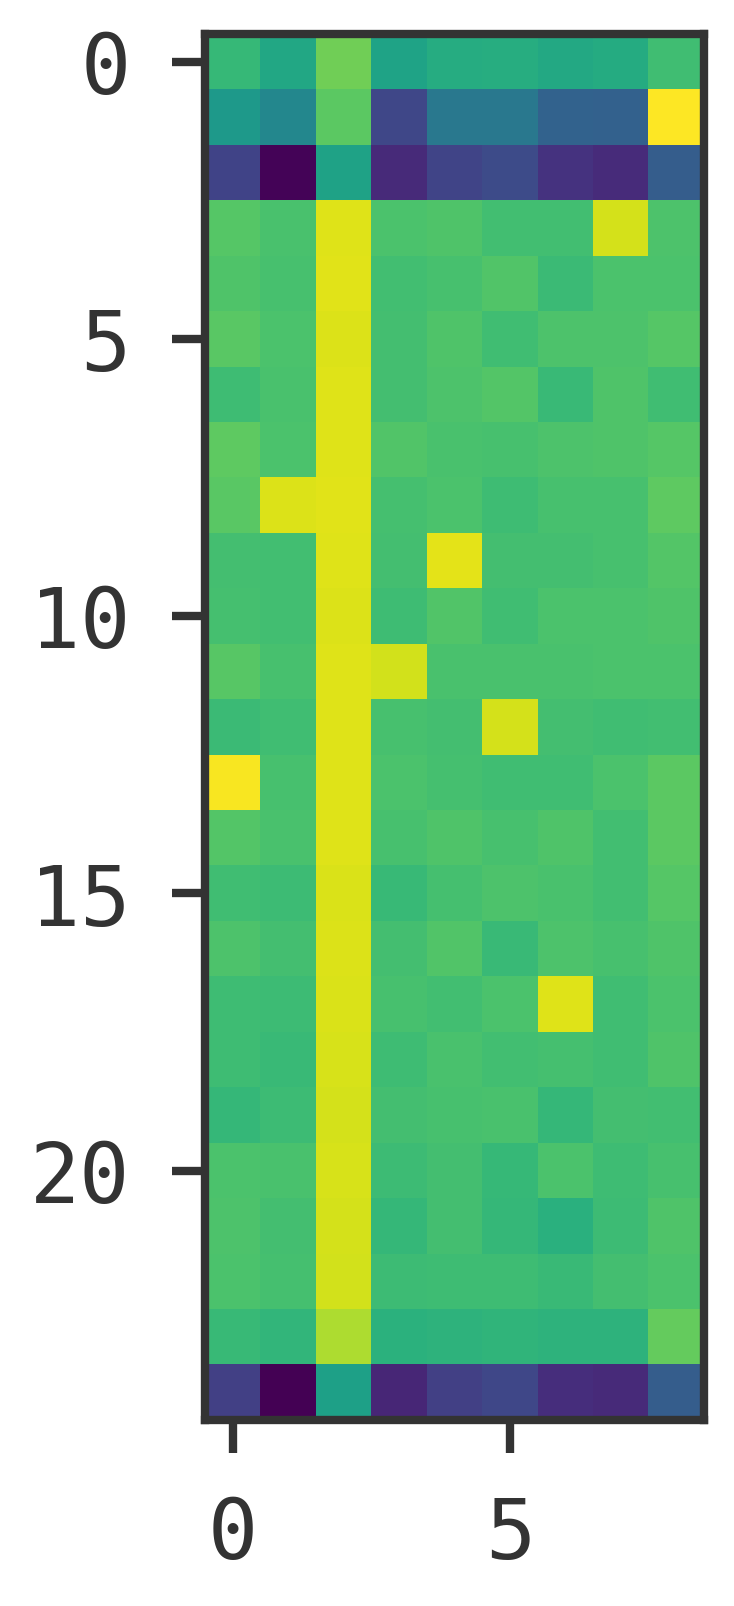

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(np.array(emb.logits[0,:,0:25].T))
plt.show()

In [63]:
# outputs = fullmodel.generate(input_ids=input_ids)
# tokenizer.decode(outputs[0])
# tokenizer.get_vocab()

In [65]:
# Load one dataset

import json

disprot_file = "AF2_testset.json"
with open(disprot_file) as infmt:
    disprot_dict = json.load(infmt)

In [95]:
from tqdm import tqdm

protids = list(disprot_dict.keys())
test_prot = protids[3]

target_seq = disprot_dict[test_prot]['seq']
input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

loss_sequence = list()
for i in tqdm(range(len(target_seq))):
    masked_seq = [sequence_masker(input_seq[0], i, i+1)]
    
    tmp = tokenizer(masked_seq)
    input_ids = torch.tensor(tmp['input_ids']).to(device)
    attention_mask = torch.tensor(tmp['attention_mask']).to(device)
    with torch.no_grad():
        loss = fullmodel(input_ids=input_ids, labels=input_ids).loss
        loss_sequence.append(loss.item())

100%|█████████████████████████████████████████| 194/194 [13:07<00:00,  4.06s/it]


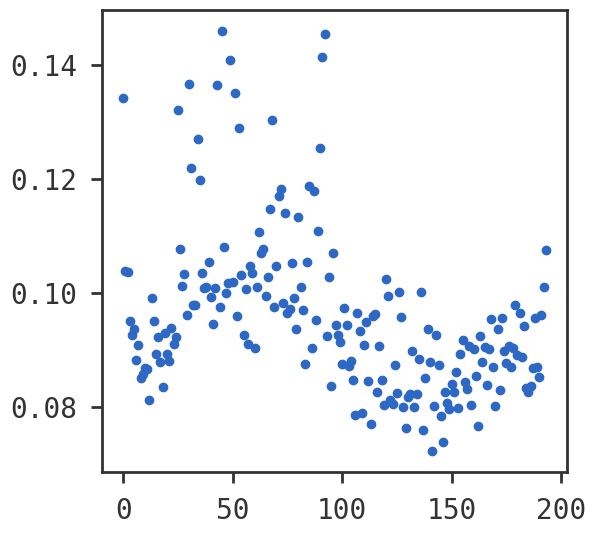

In [96]:

fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(np.arange(len(target_seq)), loss_sequence)
plt.show()

In [98]:
disprot_dict[test_prot]['disorder']

'DDDDDDDDDDDDDDDDDDDDDD----------------------------------------------------------------------------------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [100]:
disprot_dict[test_prot]['pLDDT']

['52.45',
 '57.17',
 '48.93',
 '67.42',
 '63.40',
 '49.24',
 '60.70',
 '69.77',
 '63.47',
 '63.53',
 '62.65',
 '72.57',
 '65.03',
 '63.57',
 '62.37',
 '62.72',
 '63.09',
 '62.55',
 '59.94',
 '59.81',
 '61.03',
 '63.36',
 '74.04',
 '86.28',
 '91.92',
 '94.81',
 '96.00',
 '97.15',
 '96.39',
 '96.79',
 '97.48',
 '97.51',
 '96.24',
 '96.54',
 '97.36',
 '96.40',
 '94.53',
 '95.64',
 '90.84',
 '86.36',
 '89.40',
 '90.26',
 '90.57',
 '94.44',
 '96.82',
 '96.70',
 '96.86',
 '96.84',
 '96.99',
 '97.67',
 '97.09',
 '97.17',
 '97.64',
 '97.46',
 '96.47',
 '96.54',
 '96.52',
 '96.39',
 '94.86',
 '94.91',
 '92.47',
 '93.81',
 '94.93',
 '96.42',
 '97.09',
 '97.27',
 '97.10',
 '97.77',
 '97.47',
 '97.62',
 '97.54',
 '97.70',
 '96.95',
 '97.08',
 '96.49',
 '96.04',
 '94.84',
 '94.52',
 '93.91',
 '95.03',
 '95.65',
 '94.17',
 '95.19',
 '94.74',
 '93.98',
 '95.60',
 '94.40',
 '93.06',
 '94.22',
 '95.12',
 '95.81',
 '96.63',
 '96.86',
 '95.02',
 '94.64',
 '91.12',
 '79.59',
 '58.81',
 '51.91',
 '52.90',
